In [1]:
# Installing required packages
%pip install pandas numpy pandas_profiling openpyxl sklearn torch transformers iso18245

In [1]:
import warnings
warnings.filterwarnings("ignore")

seed = 43

### Loading and Preliminary analysis of the dataset

In [17]:
# importing required libraries
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

np.random.seed(seed)

In [18]:
train_set = pd.read_excel("data/dbb4c4ff1f31-CAC+2022_Training+Data+Set+New.xlsx",dtype={'default_brand':str, 'qrated_brand':str , 'coalesced_brand':str})

In [19]:
profile = ProfileReport(train_set)
profile.to_file("info/profile_train_test_set.html")

### Preprocessings

In [20]:
x_train = train_set.drop(["cdf_seq_no","Category"], axis=1)
y_train = train_set["Category"]

In [21]:
x_train["merchant_cat_code"].fillna(0, inplace=True)

# scale merchant_cat_code (range 0-9999) to 0-0.9999 
x_train["merchant_cat_code"] = x_train["merchant_cat_code"]/10000

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

### Baseline model

In [8]:
# randomly assign classes 
y_pred_rand = np.random.randint(0,len(label_encoder.classes_)-1,len(y_train))

In [9]:
# check accuracy of the random assignment
from sklearn.metrics import classification_report
print(classification_report(y_train_encoded, y_pred_rand, target_names=label_encoder.classes_))


                                           precision    recall  f1-score   support

                   Communication Services       0.01      0.10      0.01       282
                                Education       0.01      0.10      0.02       445
                            Entertainment       0.27      0.10      0.15     11255
                                  Finance       0.00      0.12      0.01       185
            Health and Community Services       0.11      0.11      0.11      4157
           Property and Business Services       0.03      0.12      0.05      1095
                             Retail Trade       0.34      0.11      0.17     13500
                    Services to Transport       0.06      0.11      0.07      2317
Trade, Professional and Personal Services       0.14      0.11      0.13      5275
                                   Travel       0.00      0.00      0.00      1489

                                 accuracy                           0.11     40000
  

## Simple ML algo run

### Using only mCatCode

In [9]:
# use mCat code as the only feature (since it is higly correlated with the target)
x_selected = x_train[["merchant_cat_code"]]

In [12]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

clf = svm.SVC(kernel='rbf', C=1, gamma=0.1)
scores = cross_val_score(clf, x_selected, y_train_encoded, cv=5, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.63 (+/- 0.01)


In [8]:
# import naive bayes
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
scores = cross_val_score(clf, x_selected, y_train_encoded, cv=5, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.34 (+/- 0.00)


In [13]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

clf = xgb.XGBClassifier(max_depth=7, n_estimators=1000, objective='multi:softprob')

scores = cross_val_score(clf, x_selected, y_train_encoded, cv=5, n_jobs=2)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.63 (+/- 0.01)


### Using mCatCode and payment category

In [44]:
# one-hot encoding of payment_category
from sklearn.preprocessing import OneHotEncoder
oe = OneHotEncoder()
x_payment_cat_encoded = pd.DataFrame(oe.fit_transform(x_train[["payment_category"]]).toarray(), columns=oe.categories_[0])
x_selected = x_train[["merchant_cat_code"]].join(x_payment_cat_encoded)

In [47]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

clf = svm.SVC(kernel='rbf', C=1, gamma=0.1)
scores = cross_val_score(clf, x_selected, y_train_encoded, cv=5, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.63 (+/- 0.01)


In [48]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

clf = xgb.XGBClassifier(max_depth=7, n_estimators=1000, objective='multi:softprob')

scores = cross_val_score(clf, x_selected, y_train_encoded, cv=5, n_jobs=2)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.63 (+/- 0.01)


### Using all features

In [55]:
from sklearn.preprocessing import OneHotEncoder
oe = OneHotEncoder()

x_encoded = pd.DataFrame(oe.fit_transform(x_train[["payment_category","sor","db_cr_cd","is_international"]]).toarray(), columns=oe.get_feature_names())
x_selected = x_train[["merchant_cat_code","amt"]].join(x_encoded)

In [57]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

clf = svm.SVC(kernel='rbf', C=1, gamma=0.1)
scores = cross_val_score(clf, x_selected, y_train_encoded, cv=5, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.60 (+/- 0.01)


### Using payCat, merCatCode, amt

In [58]:
from sklearn.preprocessing import OneHotEncoder
oe = OneHotEncoder()

x_encoded = pd.DataFrame(oe.fit_transform(x_train[["payment_category"]]).toarray(), columns=oe.get_feature_names())
x_selected = x_train[["merchant_cat_code","amt"]].join(x_encoded)

In [59]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

clf = svm.SVC(kernel='rbf', C=1, gamma=0.1)
scores = cross_val_score(clf, x_selected, y_train_encoded, cv=5, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.60 (+/- 0.01)


### inspect rows with mCatCode null

In [ ]:
train_set[train_set['merchant_cat_code'].isna()].sample(frac=1)

## Neural Nets

### BERT features extractor

In [7]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [206]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [207]:
from transformers import BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 10,
)

# Tell pytorch to run this model on the GPU.
desc = model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [208]:
# Larger batch sizes tend to be better, and we can fit this in memory.
batch_size = 32

# I used a smaller learning rate to combat over-fitting that I was seeing in the
# validation loss. I could probably try even smaller.
learning_rate = 1e-5

# Number of training epochs. 
epochs = 4

In [209]:
import matplotlib.pyplot as plt
%matplotlib inline

def maxLen(concatenated_brand):
    len_list = []
    # For every sentence...
    for sent in concatenated_brand:
        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer.encode(sent, add_special_tokens=True)
        len_list.append(len(input_ids))

    # mean, max, min of len_list
    print('Mean sentence length: ', np.mean(len_list))
    print('Max sentence length: ', np.max(len_list))
    print('Min sentence length: ', np.min(len_list))
    plt.hist(len_list)
    plt.xlabel('Sentence length')
    plt.ylabel('Count')
    plt.title('Sentence length distribution')
    plt.show()
    return

### default_brand, qrated_brand, coalesced_brand

In [210]:
# concat default_brand, qrated_brand and coalesced_brand
concatenated_brand = x_train["default_brand"] + " " + x_train["qrated_brand"] + " " + x_train["coalesced_brand"]
concatenated_brand.fillna("", inplace=True)

Mean sentence length:  13.2321
Max sentence length:  61
Min sentence length:  2


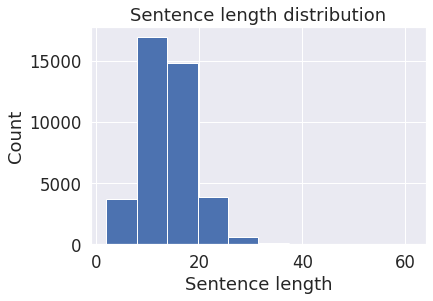

In [211]:
maxLen(concatenated_brand)

In [212]:
max_len = 50

### default_brand, qrated_brand and coalesced_brand with mCatCode

In [13]:
# concat default_brand, qrated_brand and coalesced_brand
concatenated_brand = x_train["merchant_cat_code"].astype(str) + " " + x_train["default_brand"] + " " + x_train["qrated_brand"] + " " + x_train["coalesced_brand"]
concatenated_brand.fillna("", inplace=True)

Max sentence length:  64
Mean sentence length:  16.65485
Max sentence length:  64
Min sentence length:  2


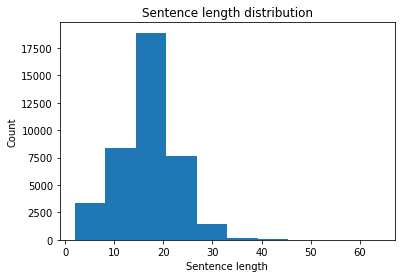

In [14]:
maxLen(concatenated_brand)

In [15]:
max_len = 50

### merchant_cat_code,default_brand, qrated_brand and coalesced_brand and translated merchant_cat_code

In [ ]:
import iso18245

def convert(x):
    try:
        return iso18245.get_mcc(str(x).zfill(4)).iso_description
    except:
        return ""
    
mcc_desc = x_train["merchant_cat_code"].astype(int).apply(lambda x: convert(x) )


In [ ]:
# concat merchant_cat_code,default_brand, qrated_brand and coalesced_brand
concatenated_brand = x_train["merchant_cat_code"].astype(str) + " " + mcc_desc + " " + x_train["default_brand"] + " " + x_train["qrated_brand"] + " " + x_train["coalesced_brand"]
concatenated_brand.fillna("", inplace=True)

In [ ]:
maxLen(concatenated_brand)

In [ ]:
max_len = 55

### Train

In [213]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

print('Encoding...')

# For every sentence...
for sent in concatenated_brand:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_train_encoded)

print('DONE.')

Encoding...
DONE.


In [214]:
import random
# First, calculate the split sizes. 80% training, 10% validation, 10% test.
train_size = int(0.8 * len(train_set))
val_size = int(0.1 * len(train_set))
test_size = len(train_set) - (train_size + val_size)

# Sanity check the sizes.
assert((train_size + val_size + test_size) == len(train_set))

# Create a list of indeces for all of the samples in the dataset.
indeces = np.arange(0, len(train_set))

# Shuffle the indeces randomly.
random.shuffle(indeces)

# Get a list of indeces for each of the splits.
train_idx = indeces[0:train_size]
val_idx = indeces[train_size:(train_size + val_size)]
test_idx = indeces[(train_size + val_size):]

# Sanity check
assert(len(train_idx) == train_size)
assert(len(test_idx) == test_size)

# With these lists, we can now select the corresponding dataframe rows using, 
# e.g., train_df = data_df.iloc[train_idx] 

print('  Training size: {:,}'.format(train_size))
print('Validation size: {:,}'.format(val_size))
print('      Test size: {:,}'.format(test_size))

  Training size: 32,000
Validation size: 4,000
      Test size: 4,000


In [215]:
from torch.utils.data import TensorDataset

# Split the samples, and create TensorDatasets for each split. 
train_dataset = TensorDataset(input_ids[train_idx], attention_masks[train_idx], labels[train_idx])
val_dataset = TensorDataset(input_ids[val_idx], attention_masks[val_idx], labels[val_idx])
test_dataset = TensorDataset(input_ids[test_idx], attention_masks[test_idx], labels[test_idx])

In [216]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [217]:
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, 
                  eps = 1e-8 
                )

In [218]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples!)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [219]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [220]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [221]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,000.    Elapsed: 0:00:11.
  Batch    80  of  1,000.    Elapsed: 0:00:22.
  Batch   120  of  1,000.    Elapsed: 0:00:33.
  Batch   160  of  1,000.    Elapsed: 0:00:44.
  Batch   200  of  1,000.    Elapsed: 0:00:56.
  Batch   240  of  1,000.    Elapsed: 0:01:07.
  Batch   280  of  1,000.    Elapsed: 0:01:18.
  Batch   320  of  1,000.    Elapsed: 0:01:30.
  Batch   360  of  1,000.    Elapsed: 0:01:41.
  Batch   400  of  1,000.    Elapsed: 0:01:53.
  Batch   440  of  1,000.    Elapsed: 0:02:04.
  Batch   480  of  1,000.    Elapsed: 0:02:16.
  Batch   520  of  1,000.    Elapsed: 0:02:28.
  Batch   560  of  1,000.    Elapsed: 0:02:40.
  Batch   600  of  1,000.    Elapsed: 0:02:51.
  Batch   640  of  1,000.    Elapsed: 0:03:03.
  Batch   680  of  1,000.    Elapsed: 0:03:15.
  Batch   720  of  1,000.    Elapsed: 0:03:27.
  Batch   760  of  1,000.    Elapsed: 0:03:39.
  Batch   800  of  1,000.    Elapsed: 0:03:51.
  Batch   840  of

In [222]:
import pandas as pd

# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap (doesn't seem to work in Colab).
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.078342,0.823186,0.73075,0:04:51,0:00:13
2,0.750434,0.772836,0.74250,0:05:00,0:00:13
3,0.644952,0.778967,0.74725,0:04:58,0:00:13
4,0.580174,0.792017,0.74725,0:04:59,0:00:13


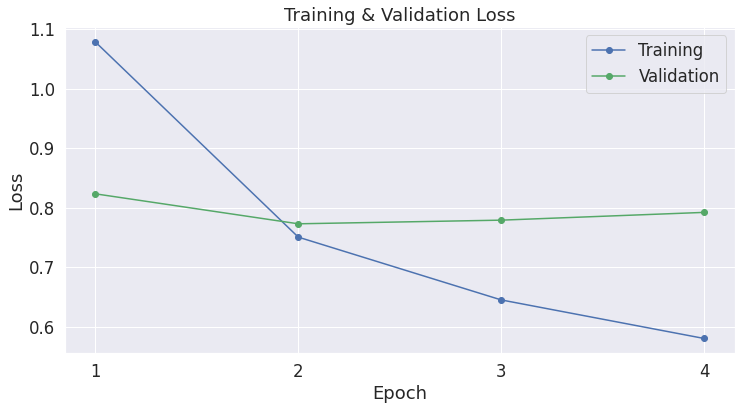

In [223]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [224]:
# Create a DataLoader to batch our test samples for us. We'll use a sequential
# sampler this time--don't need this to be random!
prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 4,000 test sentences...
    DONE.


In [225]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [30]:
from sklearn.metrics import f1_score

# Calculate the F1
f1 = f1_score(flat_true_labels, flat_predictions, average='micro')

print('F1 Score: %.3f' % f1)

F1 Score: 0.781


## Custom Bert Model

In [23]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [24]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [44]:
from transformers import BertConfig, BertModel
import torch.nn as nn

class BertTextClassifier(nn.Module):
    """
    This takes a transformer backbone and puts a slightly-modified classification head on top.
    
    """

    def __init__(self, model_name, numeric_feature_size, num_labels):
        # num_extra_dims corresponds to the number of extra dimensions of numerical/categorical data

        super().__init__()
        
        self.num_labels = num_labels
        self.config = BertConfig.from_pretrained(model_name)
        
        self.transformer = BertModel.from_pretrained(model_name, config=self.config)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size + numeric_feature_size, num_labels)


    def forward(self, input_ids, extra_data, labels, attention_mask=None):
        """
        extra_data should be of shape [batch_size, dim] 
        where dim is the number of additional numerical/categorical dimensions
        """

        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask) # [batch size, sequence length, hidden size]
        cls_embeds = outputs.last_hidden_state[:, 0, :] # [batch size, hidden size]
        concat = torch.cat((cls_embeds, extra_data.float()), dim=-1) # [batch size, hidden size+num extra dims]

        pooled_output = self.dropout(concat)
        
        logits = self.classifier(pooled_output) # [batch size, num labels]    
        
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return {
            'loss':loss,
            'logits':logits,
        }

In [47]:
# Load BertForSequenceClassification, the pretrained BERT model 
model = BertTextClassifier(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    numeric_feature_size = 1,
    num_labels = 10,
)

# Tell pytorch to run this model on the GPU.
desc = model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [68]:
# Larger batch sizes tend to be better, and we can fit this in memory.
batch_size = 32

# I used a smaller learning rate to combat over-fitting that I was seeing in the
# validation loss. I could probably try even smaller.
learning_rate = 1e-5

# Number of training epochs. 
epochs = 10

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

def maxLen(concatenated_brand):
    len_list = []
    # For every sentence...
    for sent in concatenated_brand:
        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer.encode(sent, add_special_tokens=True)
        len_list.append(len(input_ids))

    # mean, max, min of len_list
    print('Mean sentence length: ', np.mean(len_list))
    print('Max sentence length: ', np.max(len_list))
    print('Min sentence length: ', np.min(len_list))
    plt.hist(len_list)
    plt.xlabel('Sentence length')
    plt.ylabel('Count')
    plt.title('Sentence length distribution')
    plt.show()
    return

### default_brand, qrated_brand, coalesced_brand

In [70]:
# concat default_brand, qrated_brand and coalesced_brand
concatenated_brand = x_train["default_brand"] + " " + x_train["qrated_brand"] + " " + x_train["coalesced_brand"]
concatenated_brand.fillna("", inplace=True)

Mean sentence length:  19.0444
Max sentence length:  77
Min sentence length:  2


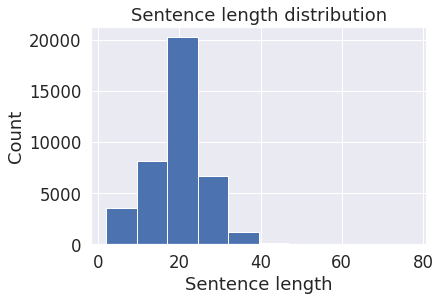

In [71]:
maxLen(concatenated_brand)

In [72]:
max_len = 50

In [73]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

print('Encoding...')

# For every sentence...
for sent in concatenated_brand:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_train_encoded)

print('DONE.')

Encoding...
DONE.


In [74]:
import random
# First, calculate the split sizes. 80% training, 10% validation, 10% test.
train_size = int(0.8 * len(train_set))
val_size = int(0.1 * len(train_set))
test_size = len(train_set) - (train_size + val_size)

# Sanity check the sizes.
assert((train_size + val_size + test_size) == len(train_set))

# Create a list of indeces for all of the samples in the dataset.
indeces = np.arange(0, len(train_set))

# Shuffle the indeces randomly.
random.shuffle(indeces)

# Get a list of indeces for each of the splits.
train_idx = indeces[0:train_size]
val_idx = indeces[train_size:(train_size + val_size)]
test_idx = indeces[(train_size + val_size):]

# Sanity check
assert(len(train_idx) == train_size)
assert(len(test_idx) == test_size)

# With these lists, we can now select the corresponding dataframe rows using, 
# e.g., train_df = data_df.iloc[train_idx] 

print('  Training size: {:,}'.format(train_size))
print('Validation size: {:,}'.format(val_size))
print('      Test size: {:,}'.format(test_size))

  Training size: 32,000
Validation size: 4,000
      Test size: 4,000


In [75]:
from torch.utils.data import TensorDataset

mcat = torch.tensor(x_train[["merchant_cat_code"]].values)

# Split the samples, and create TensorDatasets for each split. 
train_dataset = TensorDataset(input_ids[train_idx], attention_masks[train_idx], mcat[train_idx], labels[train_idx])
val_dataset = TensorDataset(input_ids[val_idx], attention_masks[val_idx], mcat[val_idx], labels[val_idx])
test_dataset = TensorDataset(input_ids[test_idx], attention_masks[test_idx], mcat[val_idx], labels[test_idx])

In [76]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [77]:
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, 
                  eps = 1e-8 
                )

In [78]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples!)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [79]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [80]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_mcat = batch[2].to(device)
        b_labels = batch[3].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       attention_mask=b_input_mask, 
                       extra_data = b_mcat,
                       labels=b_labels)

        loss = result['loss']
        logits = result['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_mcat = batch[2].to(device)
        b_labels = batch[3].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           attention_mask=b_input_mask,
                           extra_data = b_mcat,
                           labels=b_labels)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result['loss']
        logits = result['logits']
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch    40  of  1,000.    Elapsed: 0:00:11.
  Batch    80  of  1,000.    Elapsed: 0:00:22.
  Batch   120  of  1,000.    Elapsed: 0:00:33.
  Batch   160  of  1,000.    Elapsed: 0:00:44.
  Batch   200  of  1,000.    Elapsed: 0:00:55.
  Batch   240  of  1,000.    Elapsed: 0:01:06.
  Batch   280  of  1,000.    Elapsed: 0:01:18.
  Batch   320  of  1,000.    Elapsed: 0:01:29.
  Batch   360  of  1,000.    Elapsed: 0:01:40.
  Batch   400  of  1,000.    Elapsed: 0:01:51.
  Batch   440  of  1,000.    Elapsed: 0:02:03.
  Batch   480  of  1,000.    Elapsed: 0:02:14.
  Batch   520  of  1,000.    Elapsed: 0:02:25.
  Batch   560  of  1,000.    Elapsed: 0:02:36.
  Batch   600  of  1,000.    Elapsed: 0:02:48.
  Batch   640  of  1,000.    Elapsed: 0:02:59.
  Batch   680  of  1,000.    Elapsed: 0:03:10.
  Batch   720  of  1,000.    Elapsed: 0:03:22.
  Batch   760  of  1,000.    Elapsed: 0:03:33.
  Batch   800  of  1,000.    Elapsed: 0:03:45.
  Batch   840  o

In [ ]:
import pandas as pd

# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap (doesn't seem to work in Colab).
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Create a DataLoader to batch our test samples for us. We'll use a sequential
# sampler this time--don't need this to be random!
prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_mcat, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                        attention_mask=b_input_mask,
                        extra_data = b_mcat,
                        labels=b_labels)

  logits = result["logits"]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [ ]:
from sklearn.metrics import f1_score

# Calculate the F1
f1 = f1_score(flat_true_labels, flat_predictions, average='micro')

print('F1 Score: %.3f' % f1)